# Multimodal Seach Across Collections

## Load database

In [56]:
%load_ext autoreload
%autoreload 2

In [2]:
import chromadb

In [3]:
client = chromadb.PersistentClient(path="ce_vector_db")

In [38]:
db = client.get_or_create_collection(name="congruence_engine")

In [39]:
db.count()

8168

## Instantiate collection 

In [71]:
import pandas as pd
import numpy as np
from pathlib import Path
from tools.weaving_tools import plot_images
from tools.weaving_tools import SMGCollection,NMSCollection
from PIL import Image

In [41]:
collection = SMGCollection(img_folder=Path('smg_imgs'))
collection.load_from_csv('data/SMG.csv')
collection.filter_records()

In [42]:
clip_ckpt = clip_ckpt = 'clip-ViT-B-32'#'openai/clip-vit-base-patch32'
collection.load_clip_model(clip_ckpt)

## Text Query

In [146]:
query_embedding = collection.clip_model.encode('a picture of a bottle')

## Image Query

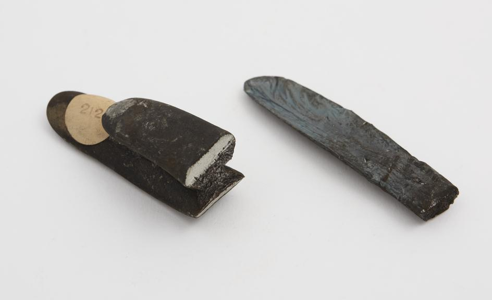

In [44]:
idx =  1000
img = Image.open(collection.df.iloc[idx]['img_path'])
img.thumbnail(size=(500,300))
img

In [45]:
query_embedding = np.array(collection.clip_model.encode(img))

## Query and Plot Results

In [151]:
results = db.query(
    query_embeddings=[list(query_embedding.astype(float))],
    n_results=10,
    where={"collection": "nms"},
)

In [152]:
#results

In [153]:
query_df = pd.DataFrame(results['metadatas'][0])

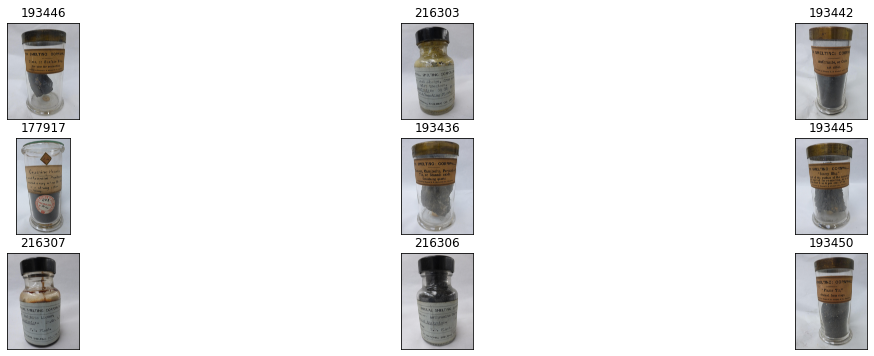

In [154]:
plot_images(query_df)

## Refine and Combine Query

In [77]:
nms = NMSCollection(img_folder=Path('mns_imgs'))
nms.load_from_csv('data/NMS.csv')
nms.filter_records()

In [79]:
img_paths = list(nms.df[nms.df.record_id.isin([175777, 175790])].img_path); img_paths

['nms_imgs/PF1089694.jpg', 'nms_imgs/PF1089702.jpg']

In [87]:
img_arrays = np.array([collection.clip_model.encode(Image.open(p)) for p in img_paths])
mean_vector = np.mean(img_arrays, axis=0)

In [88]:
results = db.query(
    query_embeddings=[list(mean_vector.astype(float))],
    n_results=10,
    where={"collection": "nms"},
)

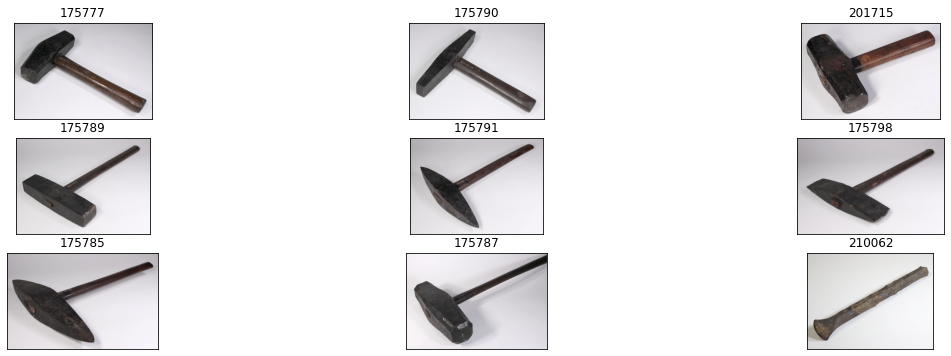

In [89]:
query_df = pd.DataFrame(results['metadatas'][0])
plot_images(query_df)

In [125]:
ids =  [5000,5001]
img_arrays = []
imgs = []
for i in ids:
    img = Image.open(collection.df.iloc[i]['img_path'])
    img_arrays.append(collection.clip_model.encode(img))
    img.thumbnail(size=(500,300))
    imgs.append(img)

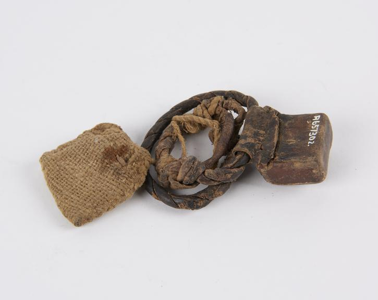

In [131]:
imgs[0]

In [128]:
mean_vector = np.mean(np.array(img_arrays), axis=0)

In [129]:
results = db.query(
    query_embeddings=[list(mean_vector.astype(float))],
    n_results=10,
    where={"collection": "nms"},
)

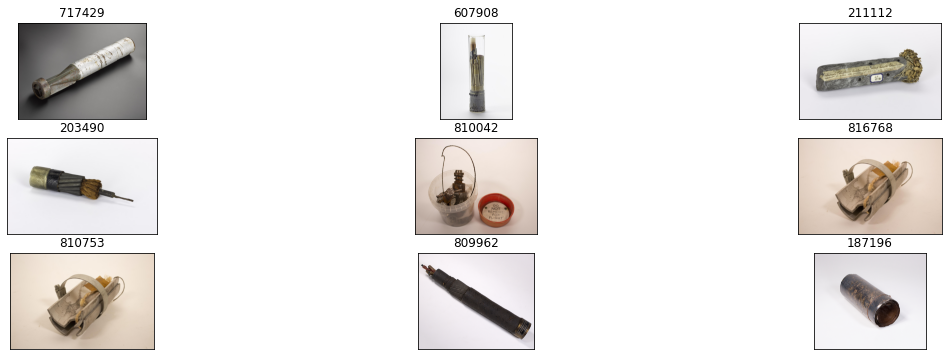

In [130]:
query_df = pd.DataFrame(results['metadatas'][0])
plot_images(query_df)

# Zero Shot Classification

In [ ]:
import transformers
transformers.__version__

In [ ]:
#!pip install -U transformers
# old version '4.25.1'

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
checkpoint = 'openai/clip-vit-base-patch32'
model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

In [ ]:
from PIL import Image

In [ ]:
idx = 3000#10
image = Image.open(nms.df.iloc[idx].img_path)

In [ ]:
print(nms.df.iloc[idx].taxonomy)

In [ ]:
import re
#pattern = re.compile()
matches = [re.search(r'[A-Z\-\s]+',str(t)) for t in nms.df.taxonomy.unique()]
matches = set([m.group().strip() for m in matches if m])
candidate_labels = list({i for i in matches if len(i) > 1})

In [ ]:
inputs = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)

In [ ]:
#inputs

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    
logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

In [ ]:
result = [
    {"score": score, "label": candidate_label}
        for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

In [ ]:
result

In [ ]:
import pandas as pd
pd.Series(scores, index=candidate_labels).plot(kind='bar')

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

result = [
    {"score": score, "label": candidate_label}
        for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

result

# Nomic Experiment

In [ ]:
from nomic import atlas
import numpy as np

In [ ]:
%%bash
nomic login pyKINnSOXSivweuAXxprY7j8NtVFI88WC7AeE3BnLAmQZ

In [ ]:
nms_clip_embeddigns = np.array(nms.dataset['clip_image_embedding'])
base_url = 'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value='
nms.df['url'] = nms.df.img_loc.apply(lambda x: base_url + x)
nms_data = [{'category': str(row.taxonomy), 'collection':'nms','id': str(i), 'url': row.url}
            for i, row in nms.df.iterrows()]

In [ ]:
smg_clip_embeddigns = np.array(smg.dataset['clip_image_embedding'])
base_url = 'https://coimages.sciencemuseumgroup.org.uk/images/'
smg.df['url'] = smg.df.img_loc.apply(lambda x: base_url + x)
smg_data = [{'category': str(row.taxonomy), 'collection':'smg','id': str(i), 'url': row.url}
            for i, row in smg.df.iterrows()]

In [ ]:
embeddings = np.concatenate([nms_clip_embeddigns,smg_clip_embeddigns], axis=0)

In [ ]:
data = nms_data + smg_data

In [ ]:
len(data), len(embeddings)

In [ ]:
project = atlas.map_embeddings(embeddings=embeddings,
                                data=data,
                                id_field='id',
                                name='CE Map',
                                colorable_fields=['category','collection'],
                                reset_project_if_exists=True)

In [ ]:
nms.df['tax_simpl'] = nms.df.taxonomy.apply(lambda x: re.search(r'[A-Z\-\s]+', str(x)))
nms.df['tax_simpl'] = nms.df['tax_simpl'].apply(lambda x: x.group() if x else 'OTHER')

In [ ]:
clip_embeddigns.shape, len(data)

In [ ]:
print(project)

In [ ]:
dir(nms)

In [ ]:
nms.load_clip_model()

In [ ]:
from transformers import pipeline

captioner = pipeline("image-to-text",model="google/pix2struct-textcaps-base")

In [ ]:

idx = 302
captioner(nms.df.iloc[idx].img_path)

In [ ]:
Image.open(nms.df.iloc[idx].img_path)

In [ ]:
import pandas as pd
from datasets import Dataset, load_dataset
from PIL import Image
import os
df = nms.df.copy()

# Define a function to load images from file paths
def load_image(image_path):
    return Image.open(image_path)

# Apply the image loading function to the DataFrame
df["image"] = df["img_path"]#.apply(load_image)
df.rename({'description':'text'}, axis=1, inplace=True)
# Create a Hugging Face dataset
dataset = Dataset.from_pandas(df[['text','image']])




In [ ]:
dataset

# Network

In [ ]:
ids2ints = {}

for i,r_id in enumerate(list(nms.df.record_id)):
    ids2ints[r_id] = i
    
for i,r_id in enumerate(list(smg.df.record_id)):
    ids2ints[r_id] = nms.df.shape[0] + i   

In [ ]:
nodes = list(ids2ints.values())

In [ ]:
def result_to_edgelist(results,e1):
    df = pd.DataFrame({k: v[0] for k,v in results.items() if k !='embeddings'} )
    df = pd.concat([df,df.metadatas.apply(pd.Series)], axis=1)
    df['distances'] = (1 / (1+ df.distances)) * 100
    return [(e1,
            ids2ints[row.record_id], 
            row.distances
                        ) for i, row in df.iterrows() 
                if e1 != ids2ints[row.record_id]]

In [ ]:
from tqdm.notebook import tqdm
nodes = []
names = []
edges = []

for i in tqdm(range(1000)): #len(nms.dataset)
    
    
    results_smg = collection.query(
            query_embeddings=[list(np.array(nms.dataset[i]['clip_image_embedding']).astype(float))],
            n_results=3,
            where={"collection": "smg"},
                )
    e1 = ids2ints[nms.dataset[i]['record_id']]
    
    edges.extend(result_to_edgelist(results_smg,e1))
    
    
    results_nms = collection.query(
            query_embeddings=[list(np.array(nms.dataset[i]['clip_image_embedding']).astype(float))],
            n_results=3,
            where={"collection": "nms"},
                )
    
    edges.extend(result_to_edgelist(results_nms,e1))

In [ ]:
nodes = []
for i in edges:
    nodes.extend(i[:2])
nodes = list(set(nodes))

In [ ]:
ints2ids = {v : k for k,v in ids2ints.items()}

In [ ]:
label = [str(ints2ids[n]) for n in nodes] 

In [ ]:
from pyvis.network import Network
#net = Network(notebook=True)
net = Network(height="750px", 
              width="100%", 
              bgcolor="#222222", 
              font_color="white", 
              cdn_resources='remote', 
              #filter_menu=True, 
              notebook=True)

net.add_nodes(
    nodes,
    label=label,
    color=["#00bfff" if i < nms.df.shape[0] else "#ffc0cb" for i in nodes],
)

In [ ]:
net.add_edges(edges)

In [ ]:
#net.show("network.html")

In [ ]:
#net.show_buttons(filter_=['physics'])

In [ ]:
net = draw_network(
    nodes, df, minium_weight=0, repulsion=100, spring_length=500, buttons=["physics"]
)
net.show("match_with_buttons.html")

In [ ]:
net.show_buttons()

In [ ]:
# Image to Text

In [3]:
!pip install bitsandbytes sentencepiece accelerate transformers

In [1]:
checkpoint = "HuggingFaceM4/idefics-9b"

In [2]:
import torch
from transformers import IdeficsForVisionText2Text, AutoProcessor, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
)

processor = AutoProcessor.from_pretrained(checkpoint)

model = IdeficsForVisionText2Text.from_pretrained(
    checkpoint,
    quantization_config=quantization_config,
    device_map="auto"
)

ImportError: Using `load_in_8bit=True` requires Accelerate: `pip install accelerate` and the latest version of bitsandbytes `pip install -i https://test.pypi.org/simple/ bitsandbytes` or pip install bitsandbytes` 

In [6]:
!pip install -i https://test.pypi.org/simple/ bitsandbytes

Looking in indexes: https://test.pypi.org/simple/
